In [84]:
import sys
print(sys.executable)

/home/sherry/anaconda3/envs/graph/bin/python


In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn import plotting
from openpyxl import load_workbook
import networkx as nx
import itertools
import gmatch4py as gm
from sklearn.cluster import SpectralClustering
import seaborn as sns
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats
from sklearn import decomposition
from scipy import stats
from scipy.spatial import distance

In [86]:
DATA_PATH = '/home/sherry/Dropbox/PhD/Data/TBI/TBI_Connectomes_wSubcort'
N_NODE = 116

In [106]:
subj_list = [x for x in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, x))]
#subj_list = np.loadtxt(os.path.join(DATA_PATH, 'IntersectionList.txt'), dtype=str)
label_list = [0 if x.startswith('c') else 1 for x in subj_list]
file_list = [os.listdir(os.path.join(DATA_PATH, subj)) for subj in subj_list]
df = pd.DataFrame({'Subject':subj_list, 'DX_Group':label_list, 'Filelist':file_list})
df

,Subject,DX_Group,Filelist
0,p065,1,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
1,p027,1,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
2,c020,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
3,c034,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
4,c017,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
...,...,...,...
73,c028,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
74,c038,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
75,c015,0,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."
76,p012,1,"[DTI_det_10M_nonnormalized_216_raw_s1.txt, DTI..."


In [7]:
conn_dict = {}
for subj in subj_list:
    filelist = [x for x in df[df['Subject']==subj]['Filelist'].tolist()[0] if str(N_NODE) in x.split('_')]
    filelist.sort()
    filepath = os.path.join(DATA_PATH, subj, filelist[0])
    conn_dict[subj] = np.loadtxt(filepath)

In [8]:
subj_list.remove('p021')

In [9]:
'''
def edge_subst_cost(e1, e2):
    return abs(e1['weight'] - e2['weight']) / (abs(e1['weight']) + abs(e2['weight']))


ged1 = np.zeros((len(subj_list), len(subj_list)))
for i in range(len(subj_list[0:1])):
    for j in range(i+1, len(subj_list[0:2])):
        G1 = nx.from_numpy_array(conn_dict[subj_list[i]]['sconn'][0])
        G2 = nx.from_numpy_array(conn_dict[subj_list[j]]['sconn'][0])
        for v in nx.optimize_graph_edit_distance(G1, G2, node_match=None, edge_match=None,
                                           node_subst_cost=None, node_del_cost=None, node_ins_cost=None,
                                           edge_subst_cost=, edge_del_cost=None, edge_ins_cost=None,
                                           upper_bound=None):
            ged1[i,j] = v
'''

# graph edit distance for structural connectivity
# node deletion & addition cost is 1, node substisution cost is 0 (node attributes are not considered)
# edge deletion & addition cost is 1

print('Create graphs...')
Glist = []
for subj in subj_list:
    Glist.append(nx.from_numpy_array(conn_dict[subj]))

print('Compute edit distance...')
ged_fun = gm.GraphEditDistance(1,1,1,1)
ged_pc = ged_fun.compare(Glist,None)
ged_pc_sim = ged_fun.similarity(ged_pc)

Create graphs...
Compute edit distance...


In [10]:
print(ged_pc_sim)
np.savetxt('graph_distance_TBI.txt', ged_pc_sim)

[[1.         0.05172414 0.01724138 ... 0.02586207 0.02586207 0.06034483]
 [0.05172414 1.         0.         ... 0.02586207 0.03448276 0.01724138]
 [0.01724138 0.         1.         ... 0.01724138 0.05172414 0.07758621]
 ...
 [0.02586207 0.02586207 0.01724138 ... 1.         0.06896552 0.03448276]
 [0.02586207 0.03448276 0.05172414 ... 0.06896552 1.         0.04310345]
 [0.06034483 0.01724138 0.07758621 ... 0.03448276 0.04310345 1.        ]]


In [31]:
#ged_pc_sim = np.loadtxt('graph_distance_TBI.txt')

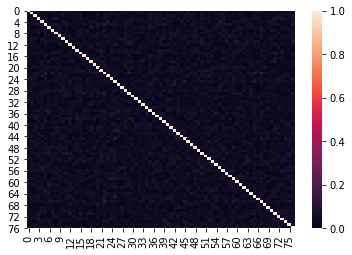

In [11]:
sns.heatmap(ged_pc_sim)

In [12]:
clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(ged_pc_sim)
print(clustering.labels_)

[1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1
 1 1 0]


/home/sherry/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [13]:
pca = decomposition.PCA(n_components=2).fit(ged_pc_sim)
embeddings_pca = pca.transform(ged_pc_sim)
print(embeddings_pca.shape)

(77, 2)


In [14]:
embeddings = TSNE(n_components=2, n_jobs=8).fit_transform(ged_pc)
print(embeddings.shape)

(77, 2)


In [34]:
df = df.set_index('Subject')
gt_label = list(df.loc[subj_list]['DX_Group'])
df = df.reset_index()
print(gt_label)

[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]


In [42]:
ged_label = pd.DataFrame({'Subject': subj_list,
                          'GEDLabel': clustering.labels_,
                          'GTLabel': gt_label,
                          'TSNE1': list(embeddings[:, 0]),
                          'TSNE2': list(embeddings[:, 1]),
                          'PCA1': list(embeddings_pca[:, 0]),
                          'PCA2': list(embeddings_pca[:, 1])})
df_ged = df.merge(ged_label, on='Subject') 
df_ged['GEDLabel'] = 1 - df_ged['GEDLabel']

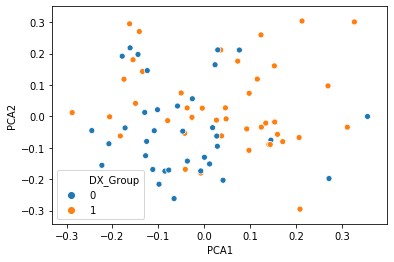

In [43]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='PCA1', y='PCA2', data=df_ged, hue=df_ged['DX_Group'])

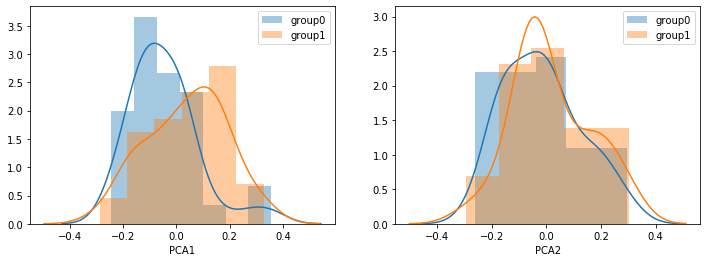

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.distplot(df_ged[df_ged['GTLabel'] == 0]['PCA1'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GTLabel'] == 1]['PCA1'], kde=True, label='group1')
plt.legend()
plt.subplot(1,2,2)
sns.distplot(df_ged[df_ged['GEDLabel'] == 0]['PCA2'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GEDLabel'] == 1]['PCA2'], kde=True, label='group1')
plt.legend()

In [45]:
accuracy = (df_ged['GEDLabel'] == df_ged['GTLabel']).sum()/len(df_ged)
print(accuracy)

0.6623376623376623


In [56]:
class distance_FC(object):
    def __init__(self, FC1, FC2, eig_thresh=10**(-3)):
        self.FC1 = FC1
        self.FC2 = FC2
        self.eig_thresh = eig_thresh

        # ensure symmetric
        self.FC1 = self._ensure_symmetric(self.FC1)
        self.FC2 = self._ensure_symmetric(self.FC2)

    def _ensure_symmetric(self, Q):
        '''
        computation is sometimes not precise (round errors),
        so ensure matrices that are supposed to be
        symmetric are symmetric
        '''
        return (Q + np.transpose(Q))/2

    def _vectorize(self, Q):
        '''
        given a symmetric matrix (FC), return unique
        elements as an array. Ignore diagonal elements
        '''
        # extract lower triangular matrix
        tri = np.tril(Q, -1)

        vec = []
        for ii in range(1, tri.shape[0]):
            for jj in range(ii):
                vec.append(tri[ii, jj])
        
        return np.asarray(vec)

    def geodesic(self):
        '''
        dist = sqrt(trace(log^2(M)))
        M = Q_1^{-1/2}*Q_2*Q_1^{-1/2}
        '''
        # compute Q_1^{-1/2} via eigen value decmposition
        u, s, _ = np.linag.svd(self.FC1, full_matrices=True)

        ## lift very small eigen values
        for ii, s_ii in enumerate(s):
            if s_ii < self.eig_thresh:
                s[ii] = self.eig_thresh

        '''
        since FC1 is in S+, u = v, u^{-1} = u'
        FC1 = usu^(-1)
        FC1^{1/2} = u[s^{1/2}]u'
        FC1^{-1/2} = u[s^{-1/2}]u'
        '''
        FC1_mod = u @ np.diag(s**(-1/2)) @ np.transpose(u)
        M = FC1_mod @ self.FC2 @ FC1_mod

        '''
        trace = sum of eigenvalues;
        np.logm might have round errors,
        implement using svd instead
        '''
        _, s, _ = np.linag.svd(M, full_matrices=True)

        return np.sqrt(np.sum(np.log(s)**2))

    def pearson(self):
        '''
        conventional Pearson distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)

        corr, p = stats.pearsonr(vec1, vec2)
        return (1 - corr)/2, p

    def spearman(self):
        '''
        Spearman distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)

        corr, p = stats.spearmanr(vec1, vec2)
        return (1 - corr)/2, p

    def euclidean(self):
        '''
        Euclidean distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)
        return distance.euclidean(vec1, vec2)

    def canberra(self):
        '''
        Euclidean distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)
        return distance.canberra(vec1, vec2)

In [57]:
ged_pc_dist = 1 - ged_pc_sim

In [58]:
df_ged = df_ged.reset_index()
df_ged = df_ged.set_index('Subject')
ged_pc = []
ged_pp = []
ged_cc = []

edist_pc = []
edist_pp = []
edist_cc = []

cdist_pc = []
cdist_pp = []
cdist_cc = []

pdist_pc = []
pdist_pp = []
pdist_cc = []
ppval_pc = []
ppval_pp = []
ppval_cc = []

sdist_pc = []
sdist_pp = []
sdist_cc = []
spval_pc = []
spval_pp = []
spval_cc = []

for i in range(len(subj_list)):
    for j in range(i+1, len(subj_list)):
        isubj = subj_list[i]
        jsubj = subj_list[j]
        iflag = df_ged.loc[isubj]['DX_Group']
        jflag = df_ged.loc[jsubj]['DX_Group']
        iconn = conn_dict[isubj]
        jconn = conn_dict[jsubj]
        dist_req = distance_FC(iconn, jconn)
        pdist, ppval = dist_req.pearson()
        sdist, spval = dist_req.spearman()
        edist = dist_req.euclidean()
        cdist = dist_req.canberra()
        if iflag==1 and jflag==1:
            ged_pp.append(ged_pc_dist[i,j])
            pdist_pp.append(pdist)
            ppval_pp.append(ppval)
            sdist_pp.append(sdist)
            spval_pp.append(spval)
            edist_pp.append(edist)
            cdist_pp.append(cdist)
        elif iflag==0 and jflag==0:
            ged_cc.append(ged_pc_dist[i,j])
            pdist_cc.append(pdist)
            ppval_cc.append(ppval)
            sdist_cc.append(sdist)
            spval_cc.append(spval)
            edist_cc.append(edist)
            cdist_cc.append(cdist)
        else:
            ged_pc.append(ged_pc_dist[i,j])
            pdist_pc.append(pdist)
            ppval_pc.append(ppval)
            sdist_pc.append(sdist)
            spval_pc.append(spval)
            edist_pc.append(edist)
            cdist_pc.append(cdist)

In [75]:
df_dist = pd.DataFrame({'type': ['pc']*len(ged_pc)+['pp']*len(ged_pp)+['cc']*len(ged_cc),
                        'GED': ged_pc+ged_pp+ged_cc,
                        'EuclideanDist': edist_pc+edist_pp+edist_cc,
                        'CanberraDist': cdist_pc+cdist_pp+cdist_cc,
                        'PearsonDist': pdist_pc+pdist_pp+pdist_cc,
                        'PearsonPval': ppval_pc+ppval_pp+ppval_cc,
                        'SpearmanDist': sdist_pc+sdist_pp+sdist_cc,
                        'SpearmanPval': spval_pc+spval_pp+spval_cc})
df_dist['EuclideanDist'] = df_dist['EuclideanDist']/df_dist['EuclideanDist'].max()
df_dist['CanberraDist'] = df_dist['CanberraDist']/df_dist['CanberraDist'].max()
df_dist['PearsonDist'] = df_dist['PearsonDist']/df_dist['PearsonDist'].max()
df_dist['SpearmanDist'] = df_dist['SpearmanDist']/df_dist['SpearmanDist'].max()

columns = ['GED', 'EuclideanDist', 'CanberraDist', 'PearsonDist', 'SpearmanDist']
tests = ['mean(pc)', 'mean(pp)', 'mean(cc)',
         'std(pc)', 'std(pp)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(pp)', 'Normality_stats(cc)',
         'Normality_p(pc)', 'Normality_p(pp)', 'Normality_p(cc)',
         'levene_stats(pc/pp)', 'levene_stats(pc/cc)', 'levene_stats(pp/cc)',
         'levene(pc/pp)', 'levene(pc/cc)', 'levene(pp/cc)',
         't-test_stats(pc/pp)', 't-test_stats(pc/cc)', 't-test_stats(pp/cc)',
         't-test_p(pc/pp)', 't-test_p(pc/cc)', 't-test_p(pp/cc)',
         't-test_es(pc/pp)', 't-test_es(pc/cc)', 't-test_es(pp/cc)',
         'mannwhitneyu_stats(pc/pp)', 'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_stats(pp/cc)',
         'mannwhitneyu_p(pc/pp)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_p(pp/cc)',
         'mannwhitneyu_es(pc/pp)', 'mannwhitneyu_es(pc/cc)', 'mannwhitneyu_es(pp/cc)',
         'ANOVA_stats', 'ANOVA_p']

alpha = 0.01
df_test = pd.DataFrame({'tests': tests})
for column in columns:
    g0 = df_dist[df_dist['type'] == 'pc'][column]
    g1 = df_dist[df_dist['type'] == 'pp'][column]
    g2 = df_dist[df_dist['type'] == 'cc'][column]

    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    if p0 < alpha:
        statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    else:
        statistics0, p0 = stats.ttest_ind(g0, g1)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    if p1 < alpha:
        statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    else:
        statistics1, p1 = stats.ttest_ind(g0, g2)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    if p2 < alpha:
        statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    else:
        statistics2, p2 = stats.ttest_ind(g1, g2)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[column] = test_score_list

df_test = df_test.set_index('tests')

In [76]:
tests_filter = [x for x in tests if 'mean' in x or 'std' in x or 'mannwhitneyu' in x]
df_test.loc[tests_filter]

,GED,EuclideanDist,CanberraDist,PearsonDist,SpearmanDist
tests,,,,,
mean(pc),0.965312,7.548754e-01,0.856129,6.637633e-01,7.570091e-01
mean(pp),0.964346,7.755214e-01,0.852106,6.845760e-01,7.723106e-01
mean(cc),0.961258,7.178270e-01,0.851019,6.141653e-01,7.209150e-01
std(pc),0.017584,5.692029e-02,0.043405,8.279136e-02,6.011911e-02
std(pp),0.017970,5.705367e-02,0.045287,8.222286e-02,5.838152e-02
std(cc),0.017316,4.716109e-02,0.036998,6.646545e-02,4.834957e-02
mannwhitneyu_stats(pc/pp),649377.500000,5.057660e+05,670139.000000,5.387410e+05,5.345830e+05
mannwhitneyu_stats(pc/cc),495672.500000,6.020100e+05,460271.000000,5.933120e+05,5.897070e+05
mannwhitneyu_stats(pp/cc),283496.000000,3.994730e+05,253170.000000,3.831960e+05,3.842290e+05


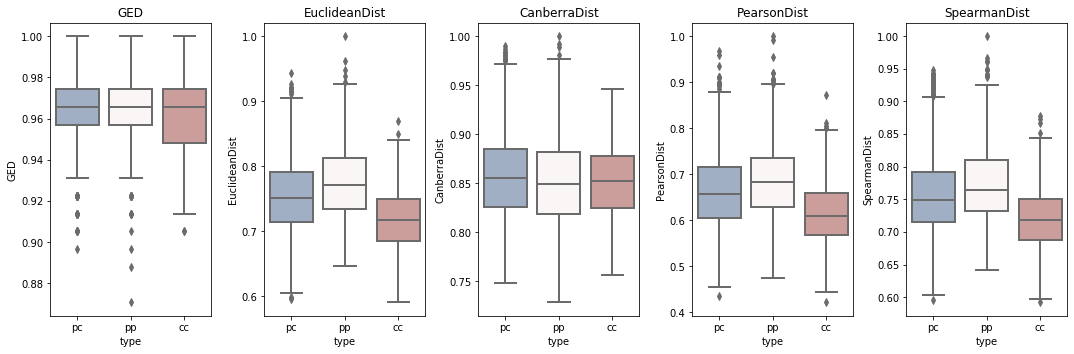

In [81]:
# Box plot
plt.figure(figsize=(15, 5))
columns = ['GED', 'EuclideanDist', 'CanberraDist', 'PearsonDist', 'SpearmanDist']
for i in range(len(columns)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist, x='type', y=columns[i])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(columns[i])
plt.tight_layout(pad=1.0)
plt.show()